# PCA-based manifolds

Author: steeve.laquitaine@epfl.ch; laquitainesteeve@gmail.com

**Learning outcomes**:

* Know how to <u>compute manifolds for large populations of neurons</u>, using a simple machine learning technique, `PCA`, in the absence of noise.
* Know what is the <u>representational geometry framework</u>.
* Know how the manifold geometry depends on its individual neurons' tuning functions.
* Know how to <u>measure the dimensionality of neural manifolds</u>, with `PCA`.

**Python prerequisites**

* installing and importing libraries
* functions
* plotting

**Readings**

* Kriegeskorte, N., & Wei, X. X. (2021). Neural tuning and representational geometry. Nature Reviews Neuroscience, 22(11), 703-718.



## Setup

In [ ]:
!pip install scipy

In [ ]:
# LIBRARIES
from scipy.stats import vonmises      # numerical processing
import numpy as np                    # numerical processing
from matplotlib import pyplot as plt  # plot
from sklearn.decomposition import PCA # dimensionality reduction
import seaborn

# PLOT PARAMETERS
FIGSIZE = (8,8)

In [ ]:
def plot_homogeneously_tuned_responses(params:dict, plot:bool=True):
  """Compute and plot tuning functions for a population of neurons.

  Returns:
    responses (np.ndarray): a matrix of responses for neurons in rows
    (by preferred orientation) x stimulus orientations in columns
  """
  # calculate homogeneously separate orientation selectivities for each neuron
  pref_orientations = np.linspace(-180, 180, params["n_neurons"])
  responses = []

  # concatenate each neuron response to all stimulus orientations
  for neuron_i, pref_orientation_i in enumerate(pref_orientations):
    this_neuron_responses = vonmises.pdf(pref_orientation_i * np.pi / 180, params["strength"], params["orientations"] * np.pi / 180)
    responses.append(this_neuron_responses)

  # cast as array
  responses = np.array(responses);

  # plot
  if plot:

    # Plot on linear space
    fig = plt.figure(figsize=FIGSIZE)

    # left panel
    left = fig.add_subplot(121)
    left.plot(responses.T);

    # legend
    left.set_title("Orientation-tuned population")
    left.set_box_aspect(1)  # square axis
    left.set_xlabel("Orientations");
    left.set_ylabel("Firing rate");
    left.set_xticks([0, len(params["orientations"])/2, len(params["orientations"])])
    left.set_xticklabels([params["orientations"][0], params["orientations"][-1]/2, params["orientations"][-1]])
    left.spines[["top","right"]].set_visible(False)

    # right panel
    right = fig.add_subplot(122)
    right.imshow(responses, cmap="gray", aspect='5')
    right.set_title("Population responses")
    right.set_yticks([])
    right.set_xticks([0, len(params["orientations"])/2, len(params["orientations"])])
    right.set_xticklabels([params["orientations"][0], params["orientations"][-1]/2, params["orientations"][-1]])
    right.set_ylabel("Neurons ranked by orientation preference")
    right.set_xlabel("Stimulus orientation (deg)")
  return responses


def plot_untuned_responses(params:dict, plot:bool=True):
  """Compute and plot tuning functions for a population of neurons.

  Returns:
    responses (np.ndarray): a matrix of responses for neurons in rows
    (by preferred orientation) x stimulus orientations in columns
  """
  # create a neural population that responds randomly
  responses = np.random.rand(params["n_neurons"], len(params["orientations"]));

  # plot
  if plot:

    # Plot on linear space
    fig = plt.figure(figsize=FIGSIZE)

    # left panel
    left = fig.add_subplot(121)
    left.plot(responses.T);

    # legend
    left.set_title("Orientation-untuned population")
    left.set_box_aspect(1)  # square axis
    left.set_xlabel("Orientations");
    left.set_ylabel("Firing rate");
    left.set_xticks([0, len(params["orientations"])/2, len(params["orientations"])])
    left.set_xticklabels([params["orientations"][0], params["orientations"][-1]/2, params["orientations"][-1]])
    left.spines[["top","right"]].set_visible(False)

    # right panel
    right = fig.add_subplot(122)
    right.set_title("Population responses")
    right.imshow(responses, cmap="gray", aspect='5')
    right.set_yticks([])
    right.set_xticks([0, len(params["orientations"])/2, len(params["orientations"])])
    right.set_xticklabels([params["orientations"][0], params["orientations"][-1]/2, params["orientations"][-1]])
    right.set_ylabel("Neurons")
    right.set_xlabel("Stimulus orientation (deg)")
  return responses


def plot_manifold_from_pca(responses:np.ndarray, params:dict, plot:bool=True):
  """
  Args:
    responses (np.ndarray): neurons x stimulus
  """
  # fit pca to neural responses
  pca = PCA(n_components=params["dims"])         # parametrize pca
  manifold = pca.fit_transform(responses.T)       # apply pca
  manifold = manifold / np.max(np.abs(manifold)) # normalise the values

  # plot
  if plot:

    # setup plot parameters
    FIG_SIZE = (4,4)
    AXIS_LIM = np.max(manifold)
    DS_PLOT = 1 # downsample for plotting

    # setup plot
    fig = plt.figure(figsize=FIG_SIZE)
    plt.set_cmap('hsv')     # circular cmap

    # 3D projection
    ax = fig.add_subplot(1,1,1, projection='3d')
    ax.view_init(20, 45, 0) # elevation, azimuth, roll

    # color the stimulus orientations
    cmap = params["orientations"]

    # plot neural manifold
    scat = ax.scatter(manifold[:,0], manifold[:,1], manifold[:,2], c=cmap)
    ax.set_xlim([-AXIS_LIM, AXIS_LIM])
    ax.set_ylim([-AXIS_LIM, AXIS_LIM])
    ax.set_zlim([-AXIS_LIM, AXIS_LIM])

    cbar = plt.colorbar(scat, fraction=0.026, pad=0.04)
    cbar.ax.set_ylabel('Stimulus orientations (deg)', rotation=270)

    # legend
    ax.set_title("PCA")  # square axis
    ax.set_xlabel("Dimension 1");
    ax.set_ylabel("Dimension 2");
    ax.set_zlabel("Dimension 3");
    ax.spines[["top", "right"]].set_visible(False)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.set_box_aspect((1,1,1))
  return {
      "manifold": manifold,
      "axis_lim": AXIS_LIM,
      "ax":ax
  }


## **Does the population encode the stimulus property?**

## Homogeneously tuned vs. untuned

* We simulate a population of neurons responses, in the absence of noise (simplification).


In [ ]:
# @title Set parameters
params = {
    "n_neurons": 40,
    "orientations": np.linspace(-180, 180, 181), # stimulus orientations
    "strength": 4.7 # arbitrary units (von mises concentration parameters)
}

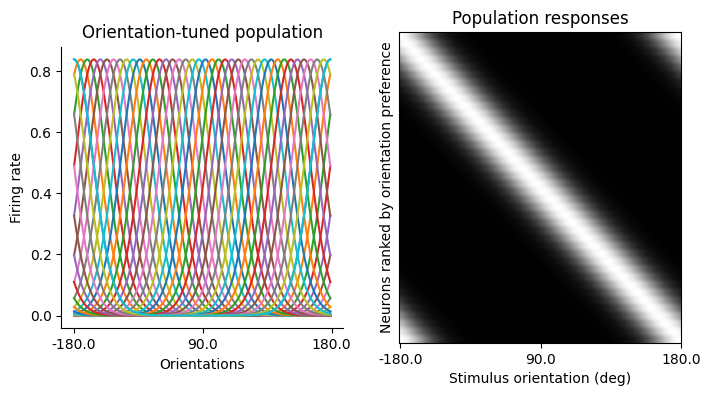

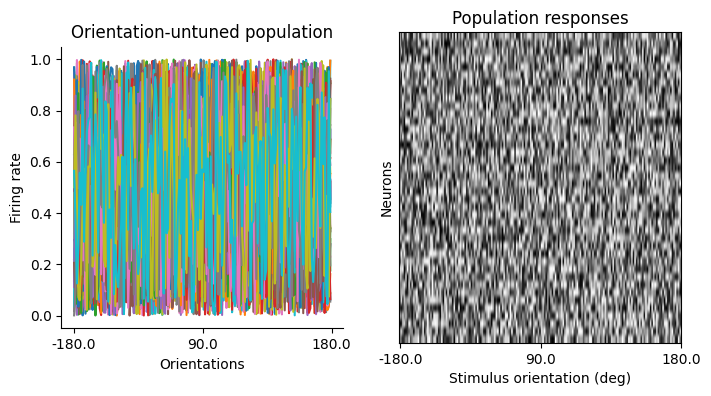

In [ ]:
# @title Simulate
# simulate homogeneously tuned population responses
tuned_responses = plot_homogeneously_tuned_responses(params, plot=True);

# simulate untuned population responses
untuned_responses = plot_untuned_responses(params, plot=True);

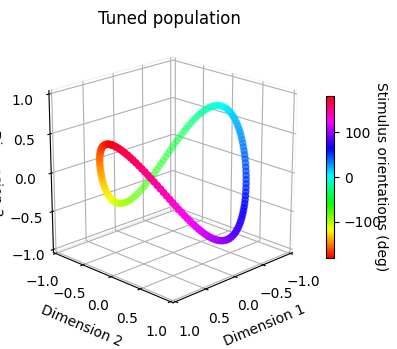

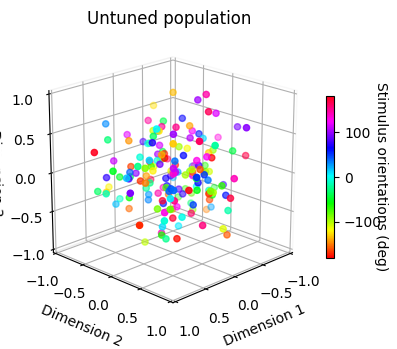

In [ ]:
# @title Reduce dimensionality with PCA
params_pca = {
    "dims": 5,  # dimensions
    "orientations": params["orientations"] # stimulus orientations
}

# learn and plot neural manifold of tuned population (takes 1 sec)
tuned_result_pca = plot_manifold_from_pca(tuned_responses, params_pca)
tuned_result_pca["ax"].set_title("Tuned population");

# learn and plot neural manifold of untuned population
untuned_result_pca = plot_manifold_from_pca(untuned_responses, params_pca)
untuned_result_pca["ax"].set_title("Untuned population");